In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision import datasets, transforms
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import *
from sklearn.utils import resample
import numpy as np
from torchvision import datasets, transforms
from torch.utils import *
import matplotlib.pyplot as plt

In [2]:
def get_data(filepath):
    return pd.read_csv(filepath) 

def split_train_test(compas_df, train=0.75):
    np.random.seed(seed=1)
    shuffled = np.random.permutation(compas_df.index)
    n_train = int(len(shuffled) * train)
    i_train, i_test = shuffled[:n_train], shuffled[n_train:]
    return compas_df.loc[i_train], compas_df.loc[i_test]


def process_data(df, label_column, protect_column):
    feature_columns = set(df.columns) - {label_column, protect_column}
    features = df[list(feature_columns)].values
    labels = df[label_column].values.reshape(-1,1)
    protect = df[protect_column].values.reshape(-1,1)
    return (features, labels, protect)

def top_k_proxy_features(df, protected_attribute, label, k):
    correlations = []
    for feature in df:
        if feature not in [protected_attribute, label]:
            correlation_score = normalized_mutual_info_score(df[feature], df[protected_attribute], average_method='arithmetic')
            correlations.append((feature, correlation_score))
    top_k = sorted(correlations, key=lambda kv:kv[1], reverse=True)[:k]
    return top_k

def df_without_k_proxies(df, protected_attribute, label, k):
    top_k = top_k_proxy_features(df, protected_attribute, label, k)
    top_k_features = set([feature for feature, _ in top_k])
    remaining_features = set(df.columns) - top_k_features
    return df[remaining_features]

In [3]:
##### Adult Dataset

# Loading the dataset
filepath = '../data/Adult Dataset/processed_adult.csv'
adult_df = pd.read_csv(filepath)
label_column = "income"
protect_column = "gender"

# Scaling the dataset
minmax_scale = preprocessing.MinMaxScaler().fit(adult_df.values)
adult_df_scaled = minmax_scale.transform(adult_df.values)
adult_df_scaled = pd.DataFrame(adult_df_scaled, index=adult_df.index, columns=adult_df.columns)

# Removing proxy features
adult_df_without_proxies = df_without_k_proxies(adult_df_scaled, protect_column, label_column, 10)


# # Splitting dataset into train, test features
# train_df, test_df = split_train_test(adult_df_scaled)
# train_features, train_labels, train_protect = process_data(train_df, label_column, protect_column)
# test_features, test_labels, test_protect = process_data(test_df, label_column, protect_column)

In [4]:
# adult_df_scaled.income.value_counts()

In [5]:
class Predictor(nn.Module):
    def __init__(self, num_features):
        super(Predictor, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        
    def forward(self, x):
        y_logits = self.linear(x)
        y_pred = F.sigmoid(y_logits)
        return y_logits, y_pred 


class Adversary(nn.Module):
    def __init__(self, num_features):
        super(Adversary, self).__init__()
        self.c = nn.Parameter(torch.ones(1), requires_grad=True)
        self.linear = nn.Linear(num_features, 1)

    def forward(self, y_logits, y):
        s = F.sigmoid((1+abs(self.c))*y_logits) 
        y = y.view_as(s) 
        x = torch.cat([s, s*y, s*(1-y)], 1)
        z_logits = self.linear(x)
        z_pred = F.sigmoid(z_logits)
        return z_logits, z_pred 


class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, label_column, protect_column):
        'Initialization'
        self.features = df.drop([label_column, protect_column], axis=1).values
        self.label = df[label_column].values
        self.protect = df[protect_column].values

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.features)

    def __getitem__(self, index):
        'Generates one sample of data'
        X = self.features[index]
        y = self.label[index]
        z = self.protect[index]
        return X, y, z
    
def train(predictor, adversary, optimizer_P, optimizer_A, device, train_loader, epoch, alpha=0.1, verbose=True):
    predictor.train()
    adversary.train()
    sum_num_correct = 0
    sum_num_adv_correct = 0
    sum_loss = 0
    num_batches_since_log = 0

    if verbose:
        batches = tqdm(enumerate(train_loader), total=len(train_loader))
        batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")
    else:
        batches = enumerate(train_loader)
    for batch_idx, (X, y, z) in batches:
        X, y, z = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float), z.to(device)
        
        optimizer_P.zero_grad()
        optimizer_A.zero_grad()
        criterion = torch.nn.BCELoss()
        
        ### Predictor 
        y_logits, y_pred = predictor(X)
        predictor_loss = criterion(y_pred, y.view_as(y_pred))
        
        ### Adversary
        z_logits, z_pred = adversary(y_logits, y)
        adversary_loss = criterion(z_pred, z.view_as(z_pred))
        

        adversary_grads = torch.autograd.grad(adversary_loss, (predictor.parameters()), retain_graph=True)
        normalize = lambda x: x / (torch.norm(x,1) + np.finfo(np.float32).tiny)

        predictor_loss.backward(retain_graph=True)
        adversary_loss.backward()

        for W_grad_predictor, b_grad_predictor in zip(predictor.linear.weight.grad, predictor.linear.bias.grad):
            W_grad_adversary = adversary_grads[0].view_as(W_grad_predictor)
            unit_W_grad_adversary = normalize(W_grad_adversary)
            W_grad_predictor -= torch.sum(unit_W_grad_adversary*W_grad_predictor)*unit_W_grad_adversary
            W_grad_predictor -= alpha*W_grad_adversary
            
            b_grad_adversary = adversary_grads[1].view_as(b_grad_predictor)
            unit_b_grad_adversary = normalize(b_grad_adversary)
            b_grad_predictor -= torch.sum(unit_b_grad_adversary*b_grad_predictor)*unit_b_grad_adversary
            b_grad_predictor -= alpha*b_grad_adversary
                
        optimizer_P.step()
        optimizer_A.step()
        
        pred = (y_pred > 0.5)*1
        correct = pred.eq(y.view_as(pred)).sum().item()
        sum_num_correct += correct
            
        adv_pred = (z_pred > 0.5)*1
        adv_correct = adv_pred.eq(z.view_as(adv_pred)).sum().item()
        sum_num_adv_correct += adv_correct
        
        sum_loss += predictor_loss.item() * batch_size
        num_batches_since_log += 1

        if verbose:
            batches.set_description(
              "Epoch {:d}: Predictor Loss ({:.2e}), Adversary Loss ({:.2e}), Accuracy ({:02.0f}%)".format(
                epoch, predictor_loss.item(), adversary_loss.item(), 100. * sum_num_correct / (num_batches_since_log * train_loader.batch_size))
            )
        
    sum_loss /= len(train_loader.dataset)
    predictor_accuracy = sum_num_correct / len(train_loader.dataset)
    adversary_accuracy = sum_num_adv_correct/len(train_loader.dataset)
    print(adversary_accuracy, " adversary's accuracy")
    return sum_loss, predictor_accuracy, adversary_accuracy

def test(predictor, device, test_loader):
    predictor.eval()
    test_loss = 0
    correct = 0
    adv_correct = 0
    test_pred = torch.zeros(0, 1, dtype=torch.torch.int64)
    test_adv_pred = torch.zeros(0, 1, dtype=torch.torch.int64)
    with torch.no_grad():
        for X, y, z in test_loader:
            X, y, z = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float), z.to(device, dtype=torch.float) 
            y_logit, y_pred = predictor(X)
            
            z_logit, z_pred = adversary(y_logit, y)
            criterion = torch.nn.BCELoss()
            loss = criterion(y_pred, y.view_as(y_pred))
            test_loss += torch.sum(loss).item() # sum up batch loss
            pred = (y_pred > 0.5)*1
            test_pred = torch.cat([test_pred, pred], 0)
            correct += pred.eq(y.view_as(pred)).sum().item()
            
            adv_pred = (z_pred > 0.5)*1
            test_adv_pred = torch.cat([test_adv_pred, adv_pred], 0)
            adv_correct += adv_pred.eq(z.view_as(adv_pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.2e}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_pred, test_adv_pred, test_loss, correct / len(test_loader.dataset), adv_correct/len(test_loader.dataset)



In [6]:
def upsample_adult(df):
    df_minority = df[df.gender==0]
    df_majority = df[df.gender==1]
    df_minority_upsampled = resample(df_minority,
                                      replace=True,
                                      n_samples=len(df_majority),
                                      random_state=1)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

def downsample_adult_gender(df):
    df_minority = df[df.gender==0]
    df_majority = df[df.gender==1]
    df_majority_downsampled = resample(df_majority,
                                       replace=False,
                                       n_samples=len(df_minority),
                                       random_state=1)
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

def downsample_adult_income(df):
    df_minority = df[df.income==1]
    df_majority = df[df.income==0]
    df_majority_downsampled = resample(df_majority,
                                       replace=False,
                                       n_samples=len(df_minority),
                                       random_state=1)
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

def downsample_adult(df):
    df_minority_greater = df[(df.income==1) & (df.gender==0)]
    df_majority_greater = df[(df.income==1) & (df.gender==1)]
    df_majority_downsampled_greater = resample(df_majority_greater,
                                       replace=False,
                                       n_samples=len(df_minority_greater),
                                       random_state=1)
    df_minority_less = df[(df.income==0) & (df.gender==0)]
    df_majority_less = df[(df.income==0) & (df.gender==1)]
    df_majority_downsampled_less = resample(df_majority_less,
                                       replace=False,
                                       n_samples=len(df_minority_less),
                                       random_state=1)
    df_downsampled = pd.concat([df_majority_downsampled_greater,
                                df_majority_downsampled_less,
                                df_minority_greater,
                                df_minority_less])
    return df_downsampled

In [7]:
# bdf = downsample_adult_income(downsample_adult(adult_df_scaled))
# bdf = downsample_adult(downsample_adult_income(adult_df_scaled))
# len(bdf[(bdf.gender==0) & (bdf.income==0)])

In [8]:
device = torch.device("cpu")

# Data Loading
label_column = "income"
protect_column = "gender"
train_df_balanced, test_df_balanced = split_train_test(downsample_adult_income(downsample_adult(adult_df_without_proxies)))
# train_df_balanced = upsample_adult(train_df)
# test_df_balanced = upsample_adult(test_df)
train_features, train_labels, train_protect = process_data(train_df_balanced, label_column, protect_column)
test_features, test_labels, test_protect = process_data(test_df_balanced, label_column, protect_column)
train_dataset = Dataset(train_df_balanced, label_column, protect_column)
test_dataset = Dataset(test_df_balanced, label_column, protect_column)
batch_size = 1000
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Parameters
num_predictor_features = train_dataset[0][0].shape[0]
num_adversary_features = 3
num_epochs = 50
lr_rate = 0.001
alpha = 0.5

# Model and Optimizer
torch.manual_seed(1)
predictor = Predictor(num_predictor_features).to(device)
adversary = Adversary(num_adversary_features).to(device)
optimizer_P = optim.Adam(predictor.parameters(), lr=lr_rate)
optimizer_A = optim.Adam(adversary.parameters(), lr=lr_rate)

train_predictor_accuracies, train_adversary_accuracies = [], []
test_predictor_accuracies, test_adversary_accuracies = [], []
for epoch in range(1, num_epochs + 1):
    _, predictor_accuracy, adversary_accuracy = train(predictor, adversary, optimizer_P, optimizer_A, device, train_loader, epoch,alpha=alpha)
    train_predictor_accuracies.append(predictor_accuracy)
    train_adversary_accuracies.append(adversary_accuracy)
    test_pred_labels, test_pred_protect, loss, test_pred_accuracy, test_adv_accuracy = test(predictor, device, test_loader)
    test_predictor_accuracies.append(test_pred_accuracy)
    test_adversary_accuracies.append(test_adv_accuracy)
    
    

/Users/joeoconnor/venv/.virtualenvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.4945076892350709  adversary's accuracy

Test set: Average loss: 8.23e-04, Accuracy: 913/1669 (55%)



/Users/joeoconnor/venv/.virtualenvs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



0.4945076892350709  adversary's accuracy

Test set: Average loss: 8.18e-04, Accuracy: 953/1669 (57%)




0.4945076892350709  adversary's accuracy

Test set: Average loss: 8.14e-04, Accuracy: 978/1669 (59%)




0.4945076892350709  adversary's accuracy

Test set: Average loss: 8.10e-04, Accuracy: 1010/1669 (61%)




0.4945076892350709  adversary's accuracy

Test set: Average loss: 8.06e-04, Accuracy: 1046/1669 (63%)




0.4945076892350709  adversary's accuracy

Test set: Average loss: 8.02e-04, Accuracy: 1071/1669 (64%)




0.4947074096265229  adversary's accuracy

Test set: Average loss: 7.99e-04, Accuracy: 1103/1669 (66%)




0.49530657080087875  adversary's accuracy

Test set: Average loss: 7.95e-04, Accuracy: 1122/1669 (67%)




0.49530657080087875  adversary's accuracy

Test set: Average loss: 7.92e-04, Accuracy: 1144/1669 (69%)




0.4963051727581386  adversary's accuracy

Test set: Average loss: 7.88e-04, Accuracy: 1159/1669 (69%)




0.49830237667265825  adversary's accuracy

Test set: Average loss: 7.85e-04, Accuracy: 1170/1669 (70%)




0.5024965048931496  adversary's accuracy

Test set: Average loss: 7.82e-04, Accuracy: 1177/1669 (71%)




0.5032953864589574  adversary's accuracy

Test set: Average loss: 7.78e-04, Accuracy: 1177/1669 (71%)




0.5126822448571999  adversary's accuracy

Test set: Average loss: 7.75e-04, Accuracy: 1191/1669 (71%)




0.5122828040742959  adversary's accuracy

Test set: Average loss: 7.72e-04, Accuracy: 1200/1669 (72%)




0.512083083682844  adversary's accuracy

Test set: Average loss: 7.69e-04, Accuracy: 1210/1669 (72%)




0.5092869982025164  adversary's accuracy

Test set: Average loss: 7.66e-04, Accuracy: 1216/1669 (73%)




0.5078889554623527  adversary's accuracy

Test set: Average loss: 7.63e-04, Accuracy: 1225/1669 (73%)




0.5042939884162173  adversary's accuracy

Test set: Average loss: 7.60e-04, Accuracy: 1227/1669 (74%)




0.5030956660675054  adversary's accuracy

Test set: Average loss: 7.58e-04, Accuracy: 1222/1669 (73%)




0.5036948272418614  adversary's accuracy

Test set: Average loss: 7.55e-04, Accuracy: 1228/1669 (74%)




0.5030956660675054  adversary's accuracy

Test set: Average loss: 7.52e-04, Accuracy: 1235/1669 (74%)




0.5002995805871779  adversary's accuracy

Test set: Average loss: 7.49e-04, Accuracy: 1239/1669 (74%)




0.49950069902137006  adversary's accuracy

Test set: Average loss: 7.46e-04, Accuracy: 1239/1669 (74%)




0.49970041941282206  adversary's accuracy

Test set: Average loss: 7.44e-04, Accuracy: 1237/1669 (74%)




0.49910125823846613  adversary's accuracy

Test set: Average loss: 7.41e-04, Accuracy: 1238/1669 (74%)




0.4989015378470142  adversary's accuracy

Test set: Average loss: 7.39e-04, Accuracy: 1242/1669 (74%)




0.49950069902137006  adversary's accuracy

Test set: Average loss: 7.36e-04, Accuracy: 1242/1669 (74%)




0.5006990213700819  adversary's accuracy

Test set: Average loss: 7.34e-04, Accuracy: 1245/1669 (75%)




0.5010984621529858  adversary's accuracy

Test set: Average loss: 7.32e-04, Accuracy: 1245/1669 (75%)




0.5010984621529858  adversary's accuracy

Test set: Average loss: 7.29e-04, Accuracy: 1242/1669 (74%)




0.5012981825444378  adversary's accuracy

Test set: Average loss: 7.27e-04, Accuracy: 1246/1669 (75%)




0.5010984621529858  adversary's accuracy

Test set: Average loss: 7.25e-04, Accuracy: 1248/1669 (75%)




0.5010984621529858  adversary's accuracy

Test set: Average loss: 7.23e-04, Accuracy: 1245/1669 (75%)




0.5020970641102457  adversary's accuracy

Test set: Average loss: 7.21e-04, Accuracy: 1247/1669 (75%)




0.5032953864589574  adversary's accuracy

Test set: Average loss: 7.18e-04, Accuracy: 1249/1669 (75%)




0.5028959456760536  adversary's accuracy

Test set: Average loss: 7.16e-04, Accuracy: 1248/1669 (75%)




0.5032953864589574  adversary's accuracy

Test set: Average loss: 7.14e-04, Accuracy: 1249/1669 (75%)




0.5034951068504094  adversary's accuracy

Test set: Average loss: 7.13e-04, Accuracy: 1248/1669 (75%)




0.5028959456760536  adversary's accuracy

Test set: Average loss: 7.11e-04, Accuracy: 1249/1669 (75%)




0.5030956660675054  adversary's accuracy

Test set: Average loss: 7.09e-04, Accuracy: 1250/1669 (75%)




0.5036948272418614  adversary's accuracy

Test set: Average loss: 7.07e-04, Accuracy: 1250/1669 (75%)




0.5034951068504094  adversary's accuracy

Test set: Average loss: 7.05e-04, Accuracy: 1252/1669 (75%)




0.5036948272418614  adversary's accuracy

Test set: Average loss: 7.03e-04, Accuracy: 1254/1669 (75%)




0.5034951068504094  adversary's accuracy

Test set: Average loss: 7.01e-04, Accuracy: 1249/1669 (75%)




0.5030956660675054  adversary's accuracy

Test set: Average loss: 6.99e-04, Accuracy: 1250/1669 (75%)




0.5032953864589574  adversary's accuracy

Test set: Average loss: 6.97e-04, Accuracy: 1254/1669 (75%)




0.5028959456760536  adversary's accuracy

Test set: Average loss: 6.96e-04, Accuracy: 1247/1669 (75%)




0.5034951068504094  adversary's accuracy

Test set: Average loss: 6.94e-04, Accuracy: 1248/1669 (75%)




0.5034951068504094  adversary's accuracy

Test set: Average loss: 6.93e-04, Accuracy: 1250/1669 (75%)



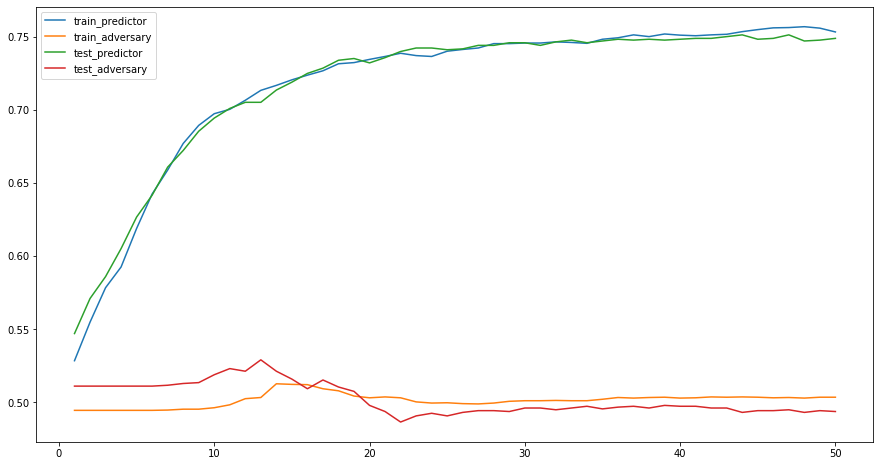

In [9]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(15,8))
plt.plot(epochs, train_predictor_accuracies, label="train_predictor")
plt.plot(epochs, train_adversary_accuracies, label="train_adversary")
plt.plot(epochs, test_predictor_accuracies, label="test_predictor")
plt.plot(epochs, test_adversary_accuracies, label="test_adversary")
plt.legend()
plt.show()

In [10]:
def binary_confusion_matrix(true_labels, pred_labels, protect, protect_group):
    indices = np.where(protect == protect_group)
    group_pred_labels = pred_labels[indices]
    group_true_labels = true_labels[indices]

    return confusion_matrix(group_true_labels, group_pred_labels)

def false_positive_rate(group_confusion_matrix):
    return group_confusion_matrix[0][1]/np.sum(group_confusion_matrix[:,1])

def true_positive_rate(group_confusion_matrix):
    return group_confusion_matrix[1][1]/np.sum(group_confusion_matrix[1,:])

def false_negative_rate(group_confusion_matrix):
    return group_confusion_matrix[1][0]/np.sum(group_confusion_matrix[:,0])

def true_negative_rate(group_confusion_matrix):
    return group_confusion_matrix[0][0]/np.sum(group_confusion_matrix[0,:])

def false_positive_rate_difference(confusion_matrix_1, confusion_matrix_2):
    return false_positive_rate(confusion_matrix_1) - false_positive_rate(confusion_matrix_2) 

def true_positive_rate_difference(confusion_matrix_1, confusion_matrix_2):
    return true_positive_rate(confusion_matrix_1) - true_positive_rate(confusion_matrix_2) 

def false_negative_rate_difference():
    return false_negative_rate(confusion_matrix_1) - false_negative_rate(confusion_matrix_2)

def average_odds_difference(confusion_matrix_1, confusion_matrix_2):
    fpr_difference = false_positive_rate_difference(confusion_matrix_1, confusion_matrix_2)
    tpr_difference = true_positive_rate_difference(confusion_matrix_1, confusion_matrix_2)
    return 0.5*(fpr_difference + tpr_difference)

def statistical_parity_difference(confusion_matrix_1, confusion_matrix_2):
    frac_prediced_positive_1 = np.sum(confusion_matrix_1[:,1])/np.sum(confusion_matrix_1)
    frac_prediced_positive_2 = np.sum(confusion_matrix_2[:,1])/np.sum(confusion_matrix_2)
    return frac_prediced_positive_1 - frac_prediced_positive_2

In [11]:
###### Fairness Metrics

female_confusion_matrix = binary_confusion_matrix(test_labels, test_pred_labels, test_protect, 0)
male_confusion_matrix = binary_confusion_matrix(test_labels, test_pred_labels, test_protect, 1)


female_fpr = false_positive_rate(female_confusion_matrix)
male_fpr = false_positive_rate(male_confusion_matrix)


female_fnr = false_negative_rate(female_confusion_matrix)
male_fnr = false_negative_rate(male_confusion_matrix)


print(female_confusion_matrix, " Females")
print(male_confusion_matrix, " Males")

print(female_fnr, male_fnr, " FNR females, males")
print(female_fpr, male_fpr, " FPR females, males")
print(statistical_parity_difference(female_confusion_matrix, male_confusion_matrix), " statistical_parity_difference")
print(average_odds_difference(female_confusion_matrix, male_confusion_matrix), " average_odds_difference")


[[339  86]
 [111 317]]  Females
[[298 113]
 [109 296]]  Males
0.24666666666666667 0.2678132678132678  FNR females, males
0.21339950372208435 0.2762836185819071  FPR females, males
-0.02877531434613706  statistical_parity_difference
-0.026547053391605138  average_odds_difference


In [12]:
test_pred_protect.unique()

tensor([0, 1])

In [13]:
# from sklearn.metrics import accuracy_score
# accuracy_score(test_labels, test_pred_labels) 